In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
%matplotlib inline

import pickle
import os
import seaborn as sns

import paysage
from paysage import backends as be
from paysage import preprocess as pre
from paysage.layers import BernoulliLayer
from paysage.layers import GaussianLayer
from paysage.models import BoltzmannMachine
from paysage import optimizers
from paysage import fit
from paysage import batch
from paysage import samplers
from paysage import schedules
from paysage import penalties as pen

Running paysage with the python backend on the cpu


In [2]:
def unpack_data(path1,path2):
    with open(os.path.join(path1, path2), 'rb') as infile:
        data = pickle.load(infile)
    data = np.unpackbits(data).reshape(-1, 1600).astype('int')
    return data

In [3]:
L = 40 # size of Linear System
T = np.linspace(0.25,4,16)
Tc = 2.26 # critical Tc/J 

path_to_data = "/Users/jai/IsingData"
ordered_path = "Ising2DFM_reSample_L40_T=1.75.pkl"
critical_path = "Ising2DFM_reSample_L40_T=2.25.pkl"
disordered_path = "Ising2DFM_reSample_L40_T=2.75.pkl"

X_ordered = unpack_data(path_to_data, ordered_path)
X_critical = unpack_data(path_to_data, critical_path)
X_disordered = unpack_data(path_to_data, disordered_path)

np.random.shuffle(X_ordered)
np.random.shuffle(X_critical)
np.random.shuffle(X_disordered)

X = {"ordered": X_ordered, "critical": X_critical, "disordered": X_disordered}

In [4]:
print(X["ordered"].shape)
print(X["critical"].shape)
print(X["disordered"].shape)

(10000, 1600)
(10000, 1600)
(10000, 1600)


In [5]:
def Adam_optimizer(initial, coefficient):
    learning_rate = schedules.PowerLawDecay(initial=initial, coefficient=coefficient)
    return optimizers.ADAM(stepsize=learning_rate)

def train_model(model, data, n_epochs, monte_carlo_steps):
    is_deep = model.num_layers > 2
    model.initialize(data, method='glorot_normal')
    opt = Adam_optimizer(initial, coefficient)
    if is_deep:
        print("layerwise pretraining")
        pretrainer = fit.LayerwisePretrain(model, data)
        pretrainer.train(opt, n_epochs, method=fit.pcd, mcsteps=monte_carlo_steps, init_method='glorot_normal')
        opt = Adam_optimizer(initial/10.0, coefficient)
    print("use persistent contrastive gradient to fit the model")
    trainer = fit.SGD(model, data)
    trainer.train(opt, n_epochs, method=fit.pcd, mcsteps=monte_carlo_steps)

def reconstruct(model, data):
    recons = model.compute_reconstructions(data).get_visible()
    return be.to_numpy_array(recons)

def compute_fantasy_particles(model, num_fantasy, num_steps, mean_field=True):
    schedule = schedules.Linear(initial=1.0, delta=1/(num_steps-1))
    fantasy = samplers.SequentialMC.generate_fantasy_state(model,
                                                          num_fantasy,
                                                          num_steps,
                                                          schedule=schedule,
                                                          beta_std=0.0,
                                                          beta_momentum=0.0)
    if mean_field:
        fantasy = model.mean_field_iteration(1, fantasy)
    fantasy_particles = fantasy.get_visible()
    return be.to_numpy_array(fantasy_particles)

def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r,
                    row_titles=None, filename=None):
    """
    Plot a grid of images.

    Args:
        image_array (numpy.ndarray)
        shape (tuple)
        vmin (optional; float)
        vmax (optional; float)
        cmap (optional; colormap)
        row_titles (optional; List[str])
        filename (optional; str)

    Returns:
        None

    """
    array = be.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)

    plt.tight_layout()
    plt.show(f)
    if filename is not None:
        f.savefig(filename)
    plt.close(f)

Training

training in the ordered phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.414597
-EnergyCoefficient: 0.309957
-HeatCapacity: 0.079982
-WeightSparsity: 0.333118
-WeightSquare: 1.897612
-KLDivergence: 1.412793
-ReverseKLDivergence: 0.019994

End of epoch 1: 
Time elapsed 2.76s
-ReconstructionError: 1.377316
-EnergyCoefficient: 0.307866
-HeatCapacity: 0.047787
-WeightSparsity: 0.333644
-WeightSquare: 1.941992
-KLDivergence: 1.412722
-ReverseKLDivergence: 0.014292

End of epoch 2: 
Time elapsed 2.25s
-ReconstructionError: 1.377772
-EnergyCoefficient: 0.307891
-HeatCapacity: 0.053651
-WeightSparsity: 0.333849
-WeightSquare: 1.931768
-KLDivergence: 1.412605
-ReverseKLDivergence: 0.015597

End of epoch 3: 
Time elapsed 2.253s
-ReconstructionError: 1.376105
-EnergyCoefficient: 0.307673
-HeatCapacity: 0.057561
-WeightSparsity: 0.333767
-WeightSquare: 1.930606
-KLDivergence: 1.414131
-ReverseKLDivergence: 0.016465

End of epoch 4: 
Time elapsed 2.242s
-Recons

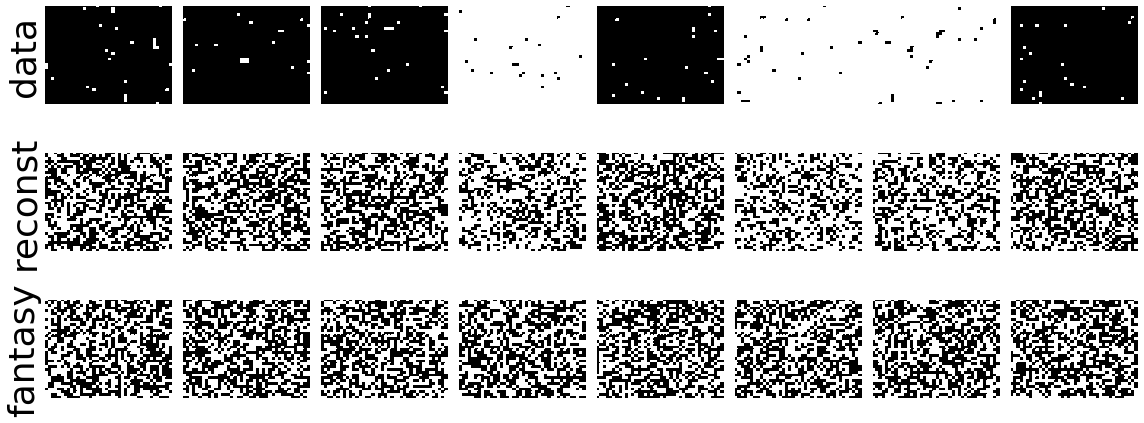

training in the critical phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.414649
-EnergyCoefficient: 0.166127
-HeatCapacity: 0.084175
-WeightSparsity: 0.335876
-WeightSquare: 1.907016
-KLDivergence: 0.411938
-ReverseKLDivergence: 0.014667

End of epoch 1: 
Time elapsed 2.296s
-ReconstructionError: 1.403947
-EnergyCoefficient: 0.160377
-HeatCapacity: 0.077077
-WeightSparsity: 0.336248
-WeightSquare: 1.941874
-KLDivergence: 0.412051
-ReverseKLDivergence: 0.011032

End of epoch 2: 
Time elapsed 2.268s
-ReconstructionError: 1.402841
-EnergyCoefficient: 0.160435
-HeatCapacity: 0.094764
-WeightSparsity: 0.336008
-WeightSquare: 1.955776
-KLDivergence: 0.412186
-ReverseKLDivergence: 0.011113

End of epoch 3: 
Time elapsed 2.442s
-ReconstructionError: 1.401841
-EnergyCoefficient: 0.160397
-HeatCapacity: 0.084801
-WeightSparsity: 0.335136
-WeightSquare: 1.980191
-KLDivergence: 0.411959
-ReverseKLDivergence: 0.010755

End of epoch 4: 
Time elapsed 3.16s
-Reco

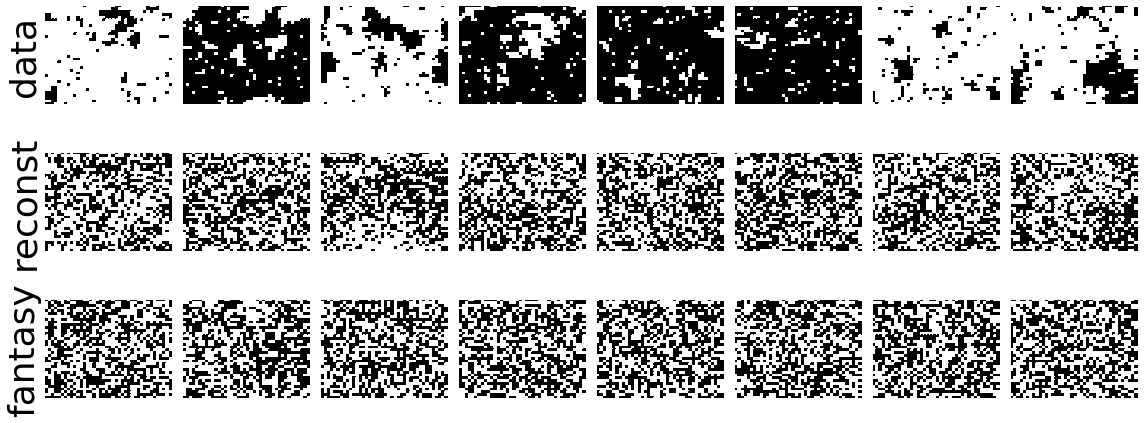

training in the disordered phase
layerwise pretraining
training model 0

Before training:
-ReconstructionError: 1.411620
-EnergyCoefficient: 0.108575
-HeatCapacity: 0.078007
-WeightSparsity: 0.334644
-WeightSquare: 1.908508
-KLDivergence: 0.031057
-ReverseKLDivergence: 0.013646

End of epoch 1: 
Time elapsed 2.344s
-ReconstructionError: 1.412217
-EnergyCoefficient: 0.100034
-HeatCapacity: 0.078377
-WeightSparsity: 0.334259
-WeightSquare: 1.951924
-KLDivergence: 0.031048
-ReverseKLDivergence: 0.010031

End of epoch 2: 
Time elapsed 2.294s
-ReconstructionError: 1.409174
-EnergyCoefficient: 0.101082
-HeatCapacity: 0.079986
-WeightSparsity: 0.331016
-WeightSquare: 2.036019
-KLDivergence: 0.030819
-ReverseKLDivergence: 0.010195

End of epoch 3: 
Time elapsed 2.334s
-ReconstructionError: 1.403513
-EnergyCoefficient: 0.100526
-HeatCapacity: 0.062875
-WeightSparsity: 0.318031
-WeightSquare: 2.401163
-KLDivergence: 0.030642
-ReverseKLDivergence: 0.009949

End of epoch 4: 
Time elapsed 2.33s
-Re

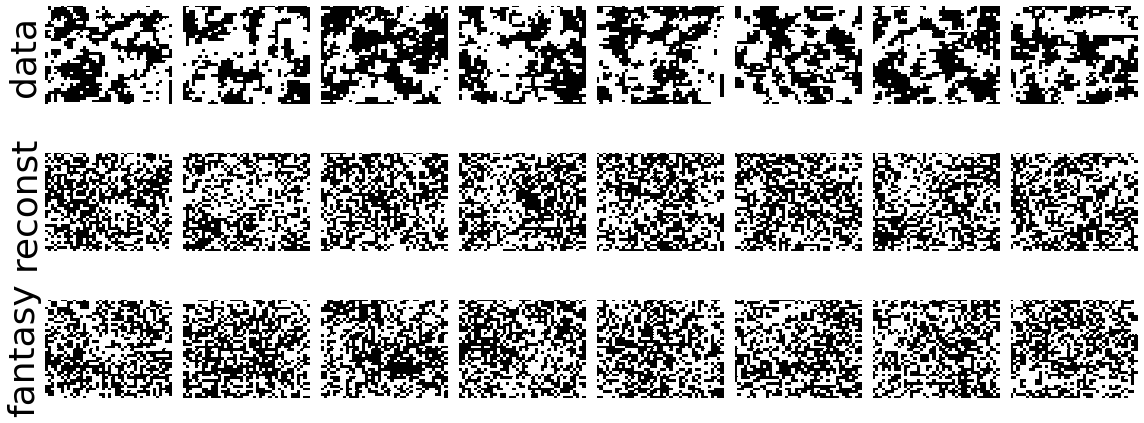

In [6]:
image_shape = (40,40) # 40x40=1600 spins in every configuration
num_to_plot = 8 # of data points to plot

batch_size = 100
num_epochs = 10
monte_carlo_steps = 2
initial = 1E-3 
coefficient = 1.0
num_fantasy_steps = 100
lmbda = 1E-6
num_hidden_units = [80, 8]

data = X

dbm_L1_reconstructions = {}
dbm_L1_fantasy = {}
true_examples = {}
dbm_models = {}

for phase in ['ordered','critical','disordered']:
    print('training in the {} phase'.format(phase))

    # set up an object to read minibatch of the data
    transform = pre.Transformation()
    batch_reader = batch.in_memory_batch(data[phase], batch_size, train_fraction=0.95, transform=transform)
    batch_reader.reset_generator(mode='train')

    ##### Bernoulli RBM
    dbm_L1 = BoltzmannMachine(
            [BernoulliLayer(batch_reader.ncols)] + \
            [BernoulliLayer(n) for n in num_hidden_units]
            )

    # add an L1 penalty to the weights
    for j_, conn in enumerate(dbm_L1.connections):
        conn.weights.add_penalty({'matrix': pen.l1_penalty(lmbda)})

    # train the model
    train_model(dbm_L1, batch_reader, num_epochs, monte_carlo_steps)

    # store model
    dbm_models[phase]=dbm_L1

    # reset the generator to the beginning of the validation set
    batch_reader.reset_generator(mode='validate')
    examples = batch_reader.get(mode='validate') # shape (batch_size, 1600)
    true_examples[phase] = examples[:num_to_plot]

    # compute reconstructions
    reconstructions = reconstruct(dbm_L1, true_examples[phase])
    dbm_L1_reconstructions[phase] = reconstructions

    # compute fantasy particles
    fantasy_particles = compute_fantasy_particles(dbm_L1,
                                                  num_to_plot,
                                                  num_fantasy_steps,
                                                  mean_field=False)
    dbm_L1_fantasy[phase] = fantasy_particles

    # plot results and save fig
    reconstruction_plot = plot_image_grid(
            np.array([
                    true_examples[phase],
                    dbm_L1_reconstructions[phase],
                    dbm_L1_fantasy[phase]
                    ]),
            image_shape, vmin=0, vmax=1,
            row_titles=["data", "reconst", "fantasy"],
            filename='DBM_Ising-'+phase+'.png')

# save data
save_file_name='./DBM_ising_training_data-L=40.pkl'
pickle.dump([dbm_models, true_examples, dbm_L1_fantasy, dbm_L1_reconstructions,
            image_shape, num_to_plot, batch_size, num_epochs, monte_carlo_steps,
            initial, coefficient, num_fantasy_steps, lmbda,num_hidden_units,
            ], open(save_file_name, "wb" ) )